# MSc Thesis - Hugo Stam

### Example 04 - Onshore and Offshore Port System Analysis

<img src="Figures/system_layout_alternative_1.2.png" style="width:1000px">
<img src="Figures/system_layout_alternative_2.2.png" style="width:1000px">
<img src="Figures/system_layout_alternative_3.2.png" style="width:1000px">

##### Investment Strategy Simulation - Adaptive terminal planning in the light of an uncertain future

* [**0. Prepare inputs:**](#0.-Prepare-inputs)<br>
   * [**0.1 Generate demand forecast scenario:**](#0.1-Generate-demand-forecast-scenario)<br>
   * [**0.2 Generate vessels:**](#0.2-Generate-vessels)<br>
* [**1. Instatiate system components:**](#1.-Instatiate-system-components)<br>
* [**2. Start simulation:**](#2.-Strart-simulation)<br>
* [**3. Report all elements:**](#3.-Report-all-elements)<br>

#### notes:


In [1]:
# packages for data handling
import numpy as np
import pandas as pd
import statistics as st

# packages related to time, space and id
import datetime, time
import platform
import random
from datetime import timedelta

# you need these dependencies packages related to the simulation
import simpy

# spatial libraries 
import shapely.geometry
from simplekml import Kml, Style

# packages for figures
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns
# sns.set(style="ticks")
# sns.set(style="darkgrid", palette = "pastel")
# sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 1.5})

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# OpenTISim package
from opentisim import container_objects
from opentisim import container_defaults
from opentisim import container_system_onshore as container_system_onshore
from opentisim import container_system_offshore_barge as container_system_offshore_barge
from opentisim import container_system_offshore_bridge as container_system_offshore_bridge

# OpenCLSim package
import openclsim.core as core
import openclsim.model as model
import openclsim.plot as plot

# Additional import to save the initialisation of the simulation
import openclsim.savesim as savesim

# Pretty-print a Python object to a stream
from pprint import pprint

# Jupyter Widgets
import ipywidgets as widgets

# Scroll to specific cell
from jupyter_helpers.utilities import scroll_to_current_cell

# 0. Prepare inputs

In [2]:
# iPython Widgests
annual_demand = widgets.IntSlider(
    value=1000000, min=500000, max=1500000, step=50000,
    description='Demand:', orientation='horizontal',
    readout=True, readout_format='d')

offshore_onshore_distance = widgets.IntSlider(
    value=40, min=20, max=60, step=20,
    description='Distance:', orientation='horizontal',
    readout=True, readout_format='d')

container_ship = widgets.Dropdown(
    options=[('Post Panamax I (6,000 TEU)', 6000), 
             ('New-Panamax (12,500 TEU)', 12500), 
             ('ULCS (21,000 TEU)', 21000)],
    value=12500, 
    description='OGV:')

barge = widgets.Dropdown(
    options=[('Small (200 TEU)', 200), 
             ('Medium (250 TEU)', 250), 
             ('Large (300 TEU)', 300)],
    value=250, 
    description='Barge:')

truck = widgets.Dropdown(
    options=[('Small (2 TEU)', 2), 
             ('Medium (2.5 TEU)', 2.5), 
             ('Large (3 TEU)', 3)],
    value=2, 
    description='Truck:')

life_cycle = widgets.IntSlider(
    value=10, min=5, max=30, step=5,
    description='Life cycle:', orientation='horizontal',
    readout=True, readout_format='d')

print('Input Values')
display(annual_demand, offshore_onshore_distance, container_ship, barge, truck, life_cycle)

Input Values


IntSlider(value=1000000, description='Demand:', max=1500000, min=500000, step=50000)

IntSlider(value=40, description='Distance:', max=60, min=20, step=20)

Dropdown(description='OGV:', index=1, options=(('Post Panamax I (6,000 TEU)', 6000), ('New-Panamax (12,500 TEU…

Dropdown(description='Barge:', index=1, options=(('Small (200 TEU)', 200), ('Medium (250 TEU)', 250), ('Large …

Dropdown(description='Truck:', options=(('Small (2 TEU)', 2), ('Medium (2.5 TEU)', 2.5), ('Large (3 TEU)', 3))…

IntSlider(value=10, description='Life cycle:', max=30, min=5, step=5)

In [3]:
offshore_distance = offshore_onshore_distance.value
demand = annual_demand.value
design_container_ship = container_ship.value
design_barge = barge.value
design_truck = truck.value
lifecycle = life_cycle.value

print('The offshore distance:', offshore_distance, 'km')
print('The annual demand:', demand, 'TEU')
print('The design container ship capacity:', design_container_ship, 'TEU')
print('The design barge capacity:', design_barge, 'TEU')
print('The design truck capacity:', design_truck, 'TEU')
print('The design life cycle:', lifecycle, 'years')

avg_parcel = design_container_ship / 8

startyear = 2020

The offshore distance: 40 km
The annual demand: 1000000 TEU
The design container ship capacity: 12500 TEU
The design barge capacity: 250 TEU
The design truck capacity: 2 TEU
The design life cycle: 10 years


## 0.1 Generate demand forecast scenario

In [4]:
# total_ocean_transport = 1000000  # TEU
# years = list(range(startyear, startyear+lifecycle))
# demand_list = []

# for year in years:
#     if year < 2025:
#         demand.append(total_ocean_transport)
#     elif year < 2030:
#         demand.append(total_ocean_transport * 1.5)
#     else:
#         demand.append(total_ocean_transport * 2.0)

# plt.plot(years, demand, 'o')
# plt.ylabel('Demand [TEU]')

In [5]:
years = list(range(startyear, startyear + lifecycle))
        
scenario_data={'year': years, 'volume': demand}

# instantiate Commodity objects, the inputs for the Commodity class
if design_container_ship == 6000:
    container_defaults.container_data['post_panamax_I_perc'] = 100
    container_defaults.container_data['new_panamax_perc'] = 0
    container_defaults.container_data['ULCS_perc'] = 0

if design_container_ship == 12500:
    container_defaults.container_data['post_panamax_I_perc'] = 0
    container_defaults.container_data['new_panamax_perc'] = 100
    container_defaults.container_data['ULCS_perc'] = 0
    
if design_container_ship == 21000:
    container_defaults.container_data['post_panamax_I_perc'] = 0
    container_defaults.container_data['new_panamax_perc'] = 0
    container_defaults.container_data['ULCS_perc'] = 100
    
print(container_defaults.container_data)

# ladens
container = container_objects.Commodity(**container_defaults.container_data)
container.scenario_data = pd.DataFrame(data=scenario_data)
# print(container.scenario_data)

# combine
demand = [container]

{'name': 'Laden', 'handling_fee': 150, 'fully_cellular_perc': 0, 'panamax_perc': 0, 'panamax_max_perc': 0, 'post_panamax_I_perc': 0, 'post_panamax_II_perc': 0, 'new_panamax_perc': 100, 'VLCS_perc': 0, 'ULCS_perc': 0}


## 0.2 Generate vessels

In [6]:
# instantiate vessels
fully_cellular = container_objects.Vessel(**container_defaults.fully_cellular_data)
panamax = container_objects.Vessel(**container_defaults.panamax_data)
panamax_max = container_objects.Vessel(**container_defaults.panamax_max_data)
post_panamax_I = container_objects.Vessel(**container_defaults.post_panamax_I_data)
post_panamax_II = container_objects.Vessel(**container_defaults.post_panamax_II_data)
new_panamax = container_objects.Vessel(**container_defaults.new_panamax_data)
VLCS = container_objects.Vessel(**container_defaults.VLCS_data)
ULCS = container_objects.Vessel(**container_defaults.ULCS_data)

vessels = [fully_cellular, panamax, panamax_max, post_panamax_I, post_panamax_II, new_panamax, VLCS, ULCS] 

# 1. Instatiate system components

## 1.1 Terminal system

Specify the variables

In [7]:
container_system_onshore.PortSystem = container_system_onshore.System(
                                      startyear = startyear,
                                      lifecycle = lifecycle,
                                      stack_equipment='rs',
                                      laden_stack='rs',
                                      crane_type_defaults=container_defaults.sts_crane_data,
                                      allowable_berth_occupancy = 0.50,
                                      transhipment_ratio = 0.0,
                                      elements = demand + vessels,
                                      laden_perc = 0.80, 
                                      reefer_perc = 0.10, 
                                      empty_perc = 0.05, 
                                      oog_perc = 0.05,
                                      operational_hours = 8640,
                                      debug=True)

container_system_offshore_barge.PortSystem = container_system_offshore_barge.System(
                                             startyear = startyear,
                                             lifecycle = lifecycle,
                                             stack_equipment='rs',
                                             laden_stack='rs',
                                             crane_type_defaults=container_defaults.sts_crane_data,
                                             offshore_distance = offshore_distance,
                                             allowable_berth_occupancy = 0.50,
                                             transhipment_ratio = 0.0,
                                             elements = demand + vessels,
                                             laden_perc = 0.80, 
                                             reefer_perc = 0.10, 
                                             empty_perc = 0.05, 
                                             oog_perc = 0.05,
                                             operational_hours = 8640,
                                             debug=True)

container_system_offshore_bridge.PortSystem = container_system_offshore_bridge.System(
                                             startyear = startyear,
                                             lifecycle = lifecycle,
                                             stack_equipment='rs',
                                             laden_stack='rs',
                                             crane_type_defaults=container_defaults.sts_crane_data,
                                             offshore_distance = offshore_distance,
                                             allowable_berth_occupancy = 0.50,
                                             transhipment_ratio = 0.0,
                                             elements = demand + vessels,
                                             laden_perc = 0.80, 
                                             reefer_perc = 0.10, 
                                             empty_perc = 0.05, 
                                             oog_perc = 0.05,
                                             operational_hours = 8640, 
                                             debug=True)

Onshore = container_system_onshore.PortSystem
OffshoreBarge = container_system_offshore_barge.PortSystem
OffshoreBridge = container_system_offshore_bridge.PortSystem

# 2. Start simulation

This method automatically generates investment decisions, parametrically derived from demand trends and a number of investment triggers.

Apply frame of reference style decisions while stepping through each year of the terminal lifecycle and check if investment is needed (in light of strategic objective, operational objective, QSC, decision recipe, intervention method):
    1. for each year evaluate the demand of each commodity (see 0.1 Demand forecast scenario)
    2. for each year evaluate the various investment decisions
    3. for each year calculate the energy costs (requires insight in realized demands)
    4. for each year calculate the demurrage costs (requires insight in realized demands)
    5. for each year calculate terminal revenues
    6. collect all cash flows (capex, opex, revenues)
    7. calculate PV's and aggregate to NPV

In [8]:
Onshore.simulate()
OffshoreBarge.simulate()
OffshoreBridge.simulate()


Onshore Terminal

Below, the various investment decisions are evaluated for the year 2020.

Simulate year: 2020
  Total vessel calls: 640
  Fully cellular calls: 0
  Panamax calls: 0
  Panamax max calls: 0
  Post Panamax I calls: 0
  Post Panamax II calls: 0
  New Panamax calls: 640
  VLCS calls: 0
  ULCS calls: 0
  Total cargo volume: 1000000
     a total of 0 [] is online; 0 total planned
     a total of 0 [] is online; 0 total planned
     a total of 0 [] is online; 0 total planned

  Start analysis:
     Berth occupancy planned (@ start of year): inf
     Berth occupancy online  (@ start of year): inf
     Crane occupancy planned (@ start of year): inf
     Crane occupancy online  (@ start of year): inf

  *** add Berth to elements
     Berth occupancy planned (after adding Berth): inf
     Berth occupancy online  (after adding Berth): inf

  *** add Quay to elements
df    Year  Terminal Capex  Maintenance  Insurance
0  2020      24334677.0          0.0        0.0
1  2021      162

c:\checkouts\opentisim\opentisim\container_system_onshore.py:1624: FutureWarning:

`item` has been deprecated and will be removed in a future version

c:\checkouts\opentisim\opentisim\container_system_onshore.py:2111: FutureWarning:

`item` has been deprecated and will be removed in a future version

c:\checkouts\opentisim\opentisim\container_system_onshore.py:1672: FutureWarning:

`item` has been deprecated and will be removed in a future version



     Stack Capacity planned  (@ start of year): 0
     Stack Capacity online   (@ start of year): 0
     Stack Capacity required (@ start of year): 12912
     Total Laden and Reefer Ground Slots required (@ start of year): 3228

  *** add Laden Stack to elements
df    Year  Terminal Capex  Maintenance
0  2020             0.0          0.0
1  2021       1312800.0          0.0
2  2022             0.0     116280.0
3  2023             0.0     116280.0
4  2024             0.0     116280.0
  *** add Laden Stack to elements
df    Year  Terminal Capex  Maintenance
0  2020             0.0          0.0
1  2021       1312800.0          0.0
2  2022             0.0     116280.0
3  2023             0.0     116280.0
4  2024             0.0     116280.0
  *** add Laden Stack to elements
df    Year  Terminal Capex  Maintenance
0  2020             0.0          0.0
1  2021       1312800.0          0.0
2  2022             0.0     116280.0
3  2023             0.0     116280.0
4  2024             0.0     116

df    Year  Terminal Capex  Maintenance
0  2020             0.0          0.0
1  2021       1312800.0          0.0
2  2022             0.0     116280.0
3  2023             0.0     116280.0
4  2024             0.0     116280.0
  *** add Laden Stack to elements
df    Year  Terminal Capex  Maintenance
0  2020             0.0          0.0
1  2021       1312800.0          0.0
2  2022             0.0     116280.0
3  2023             0.0     116280.0
4  2024             0.0     116280.0
  *** add Laden Stack to elements
df    Year  Terminal Capex  Maintenance
0  2020             0.0          0.0
1  2021       1312800.0          0.0
2  2022             0.0     116280.0
3  2023             0.0     116280.0
4  2024             0.0     116280.0
  *** add Laden Stack to elements
df    Year  Terminal Capex  Maintenance
0  2020             0.0          0.0
1  2021       1312800.0          0.0
2  2022             0.0     116280.0
3  2023             0.0     116280.0
4  2024             0.0     116280.

df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021        505000.0          0.0       0.000000
2  2022             0.0      10000.0  166153.846154
3  2023             0.0      10000.0  166153.846154
4  2024             0.0      10000.0  166153.846154
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021        505000.0          0.0       0.000000
2  2022             0.0      10000.0  166153.846154
3  2023             0.0      10000.0  166153.846154
4  2024             0.0      10000.0  166153.846154
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021        505000.0          0.0       0.000000
2  2022             0.0      10000.0  166153.846154
3  2023             0.0      10000.0  166153.846154
4  2024             0.0      10000.0  166153.84

df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021        505000.0          0.0       0.000000
2  2022             0.0      10000.0  166153.846154
3  2023             0.0      10000.0  166153.846154
4  2024             0.0      10000.0  166153.846154
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021        505000.0          0.0       0.000000
2  2022             0.0      10000.0  166153.846154
3  2023             0.0      10000.0  166153.846154
4  2024             0.0      10000.0  166153.846154
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021        505000.0          0.0       0.000000
2  2022             0.0      10000.0  166153.846154
3  2023             0.0      10000.0  166153.846154
4  2024             0.0      10000.0  166153.84

df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021         86000.0          0.0       0.000000
2  2022             0.0       8500.0  166153.846154
3  2023             0.0       8500.0  166153.846154
4  2024             0.0       8500.0  166153.846154
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021         86000.0          0.0       0.000000
2  2022             0.0       8500.0  166153.846154
3  2023             0.0       8500.0  166153.846154
4  2024             0.0       8500.0  166153.846154
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021         86000.0          0.0       0.000000
2  2022             0.0       8500.0  166153.846154
3  2023             0.0       8500.0  166153.846154
4  2024             0.0       8500.0  166153.84

4  2024             0.0      50000.0  250000.0
  *** add Stack Equipment to elements
df    Year  Terminal Capex  Maintenance    Labour
0  2020             0.0          0.0       0.0
1  2021        505000.0          0.0       0.0
2  2022             0.0      50000.0  250000.0
3  2023             0.0      50000.0  250000.0
4  2024             0.0      50000.0  250000.0
  *** add Stack Equipment to elements
df    Year  Terminal Capex  Maintenance    Labour
0  2020             0.0          0.0       0.0
1  2021        505000.0          0.0       0.0
2  2022             0.0      50000.0  250000.0
3  2023             0.0      50000.0  250000.0
4  2024             0.0      50000.0  250000.0
  *** add Stack Equipment to elements
df    Year  Terminal Capex  Maintenance    Labour
0  2020             0.0          0.0       0.0
1  2021        505000.0          0.0       0.0
2  2022             0.0      50000.0  250000.0
3  2023             0.0      50000.0  250000.0
4  2024             0.0      50

     OOG Slots planned  (@ start of year): 500
     OOG Slots online   (@ start of year): 500
     OOG Slots required (@ start of year): 478

     Number of stack Equipment online (@ start of year): 36

     Gate capacity planned     (@ start of year): 600
     Gate capacity online      (@ start of year): 600
     Gate service rate planned (@ start of year): 0.901
     Gate lane minutes         (@ start of year): 541

     Empty Handlers online (@ start of year): 45


Onshore Terminal

Below, the various investment decisions are evaluated for the year 2025.

Simulate year: 2025
  Total vessel calls: 640
  Fully cellular calls: 0
  Panamax calls: 0
  Panamax max calls: 0
  Post Panamax I calls: 0
  Post Panamax II calls: 0
  New Panamax calls: 640
  VLCS calls: 0
  ULCS calls: 0
  Total cargo volume: 1000000
     a total of 3 Berth is online; 3 total planned
     a total of 3 Quay is online; 3 total planned
     a total of 9 STS_crane is online; 9 total planned

  Start analysis:
     B

     Berth occupancy planned (@ start of year): 0.478
     Berth occupancy online  (@ start of year): 0.478
     Crane occupancy planned (@ start of year): 0.33
     Crane occupancy online  (@ start of year): 0.33

   > Quay capacity planned 1516320 TEU per year
   > Throughput online 1000000 TEU per year
     Horizontal Transport online (@ start of year): 45
     Number of STS cranes        (@ start of year): 9

     Stack Capacity planned  (@ start of year): 13120
     Stack Capacity online   (@ start of year): 13120
     Stack Capacity required (@ start of year): 12912
     Total Laden and Reefer Ground Slots required (@ start of year): 3228

     Empty Stack capacity planned  (@ start of year): 2400
     Empty Stack capacity online   (@ start of year): 2400
     Empty Stack capacity required (@ start of year): 2381
     Empty Ground Slots required   (@ start of year): 397

     OOG Slots planned  (@ start of year): 500
     OOG Slots online   (@ start of year): 500
     OOG Slots r

c:\checkouts\opentisim\opentisim\container_system_onshore.py:554: FutureWarning:

`item` has been deprecated and will be removed in a future version




Offshore Port System - Barge Connection

Below, the various investment decisions are evaluated for the year 2020.

Simulate year: 2020
  Total vessel calls: 640
  Fully cellular calls: 0
  Panamax calls: 0
  Panamax max calls: 0
  Post Panamax I calls: 0
  Post Panamax II calls: 0
  New Panamax calls: 640
  VLCS calls: 0
  ULCS calls: 0
  Total cargo volume: 1000000
     a total of 0 [] is online; 0 total planned
     a total of 0 [] is online; 0 total planned
     a total of 0 [] is online; 0 total planned

  Start analysis:
     Berth occupancy planned (@ start of year): inf
     Berth occupancy online  (@ start of year): inf
     Crane occupancy planned (@ start of year): inf
     Crane occupancy online  (@ start of year): inf

  *** add Berth to elements
     Berth occupancy planned (after adding Berth): inf
     Berth occupancy online  (after adding Berth): inf

  *** add Quay to elements
df    Year  Terminal Capex  Maintenance  Insurance
0  2020      24334677.0          0.0     

c:\checkouts\opentisim\opentisim\container_system_offshore_barge.py:1688: FutureWarning:

`item` has been deprecated and will be removed in a future version

c:\checkouts\opentisim\opentisim\container_system_offshore_barge.py:2175: FutureWarning:

`item` has been deprecated and will be removed in a future version




barges_online 14
  *** add Barge to elements
df    Year  Barge Capex  Barge Opex
0  2020   14000000.0         0.0
1  2021          0.0   1400000.0
2  2022          0.0   1400000.0
3  2023          0.0   1400000.0
4  2024          0.0   1400000.0
barges_online 15
  *** add Barge to elements
df    Year  Barge Capex  Barge Opex
0  2020   15000000.0         0.0
1  2021          0.0   1500000.0
2  2022          0.0   1500000.0
3  2023          0.0   1500000.0
4  2024          0.0   1500000.0
barges_online 16
  *** add Barge to elements
df    Year  Barge Capex  Barge Opex
0  2020   16000000.0         0.0
1  2021          0.0   1600000.0
2  2022          0.0   1600000.0
3  2023          0.0   1600000.0
4  2024          0.0   1600000.0
barges_online 17
  *** add Barge to elements
df    Year  Barge Capex  Barge Opex
0  2020   17000000.0         0.0
1  2021          0.0   1700000.0
2  2022          0.0   1700000.0
3  2023          0.0   1700000.0
4  2024          0.0   1700000.0
barges_online 1

c:\checkouts\opentisim\opentisim\container_system_offshore_barge.py:1736: FutureWarning:

`item` has been deprecated and will be removed in a future version



df    Year  Terminal Capex  Maintenance
0  2020             0.0          0.0
1  2021       1312800.0          0.0
2  2022             0.0     116280.0
3  2023             0.0     116280.0
4  2024             0.0     116280.0
  *** add Laden Stack to elements
df    Year  Terminal Capex  Maintenance
0  2020             0.0          0.0
1  2021       1312800.0          0.0
2  2022             0.0     116280.0
3  2023             0.0     116280.0
4  2024             0.0     116280.0
  *** add Laden Stack to elements
df    Year  Terminal Capex  Maintenance
0  2020             0.0          0.0
1  2021       1312800.0          0.0
2  2022             0.0     116280.0
3  2023             0.0     116280.0
4  2024             0.0     116280.0
  *** add Laden Stack to elements
df    Year  Terminal Capex  Maintenance
0  2020             0.0          0.0
1  2021       1312800.0          0.0
2  2022             0.0     116280.0
3  2023             0.0     116280.0
4  2024             0.0     116280.

df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021        505000.0          0.0       0.000000
2  2022             0.0      10000.0  166153.846154
3  2023             0.0      10000.0  166153.846154
4  2024             0.0      10000.0  166153.846154
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021        505000.0          0.0       0.000000
2  2022             0.0      10000.0  166153.846154
3  2023             0.0      10000.0  166153.846154
4  2024             0.0      10000.0  166153.846154
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021        505000.0          0.0       0.000000
2  2022             0.0      10000.0  166153.846154
3  2023             0.0      10000.0  166153.846154
4  2024             0.0      10000.0  166153.84

df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021        505000.0          0.0       0.000000
2  2022             0.0      10000.0  166153.846154
3  2023             0.0      10000.0  166153.846154
4  2024             0.0      10000.0  166153.846154
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021        505000.0          0.0       0.000000
2  2022             0.0      10000.0  166153.846154
3  2023             0.0      10000.0  166153.846154
4  2024             0.0      10000.0  166153.846154
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021        505000.0          0.0       0.000000
2  2022             0.0      10000.0  166153.846154
3  2023             0.0      10000.0  166153.846154
4  2024             0.0      10000.0  166153.84

df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021         86000.0          0.0       0.000000
2  2022             0.0       8500.0  166153.846154
3  2023             0.0       8500.0  166153.846154
4  2024             0.0       8500.0  166153.846154
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021         86000.0          0.0       0.000000
2  2022             0.0       8500.0  166153.846154
3  2023             0.0       8500.0  166153.846154
4  2024             0.0       8500.0  166153.846154
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021         86000.0          0.0       0.000000
2  2022             0.0       8500.0  166153.846154
3  2023             0.0       8500.0  166153.846154
4  2024             0.0       8500.0  166153.84

4  2024             0.0       8500.0  166153.846154
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021         86000.0          0.0       0.000000
2  2022             0.0       8500.0  166153.846154
3  2023             0.0       8500.0  166153.846154
4  2024             0.0       8500.0  166153.846154
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021         86000.0          0.0       0.000000
2  2022             0.0       8500.0  166153.846154
3  2023             0.0       8500.0  166153.846154
4  2024             0.0       8500.0  166153.846154
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021         86000.0          0.0       0.000000
2  2022             0.0       8500.0  166153.846154
3  2023          

df    Year  Terminal Capex  Maintenance    Labour
0  2020             0.0          0.0       0.0
1  2021        505000.0          0.0       0.0
2  2022             0.0      50000.0  250000.0
3  2023             0.0      50000.0  250000.0
4  2024             0.0      50000.0  250000.0
  *** add Stack Equipment to elements
df    Year  Terminal Capex  Maintenance    Labour
0  2020             0.0          0.0       0.0
1  2021        505000.0          0.0       0.0
2  2022             0.0      50000.0  250000.0
3  2023             0.0      50000.0  250000.0
4  2024             0.0      50000.0  250000.0
  *** add Stack Equipment to elements
df    Year  Terminal Capex  Maintenance    Labour
0  2020             0.0          0.0       0.0
1  2021        505000.0          0.0       0.0
2  2022             0.0      50000.0  250000.0
3  2023             0.0      50000.0  250000.0
4  2024             0.0      50000.0  250000.0
  *** add Stack Equipment to elements
df    Year  Terminal Capex  Mai

c:\checkouts\opentisim\opentisim\container_system_offshore_barge.py:556: FutureWarning:

`item` has been deprecated and will be removed in a future version




Offshore Port System - Bridge Connection

Below, the various investment decisions are evaluated for the year 2020.

Simulate year: 2020
  Total vessel calls: 640
  Fully cellular calls: 0
  Panamax calls: 0
  Panamax max calls: 0
  Post Panamax I calls: 0
  Post Panamax II calls: 0
  New Panamax calls: 640
  VLCS calls: 0
  ULCS calls: 0
  Total cargo volume: 1000000
     a total of 0 [] is online; 0 total planned
     a total of 0 [] is online; 0 total planned
     a total of 0 [] is online; 0 total planned

  Start analysis:
     Berth occupancy planned (@ start of year): inf
     Berth occupancy online  (@ start of year): inf
     Crane occupancy planned (@ start of year): inf
     Crane occupancy online  (@ start of year): inf

  *** add Berth to elements
     Berth occupancy planned (after adding Berth): inf
     Berth occupancy online  (after adding Berth): inf

  *** add Quay to elements
df    Year  Terminal Capex  Maintenance  Insurance
0  2020      24334677.0          0.0    

c:\checkouts\opentisim\opentisim\container_system_offshore_bridge.py:1705: FutureWarning:

`item` has been deprecated and will be removed in a future version

c:\checkouts\opentisim\opentisim\container_system_offshore_bridge.py:2192: FutureWarning:

`item` has been deprecated and will be removed in a future version



    Year  Truck Capex  Truck Opex
0  2020     100000.0         0.0
1  2021          0.0     10000.0
2  2022          0.0     10000.0
3  2023          0.0     10000.0
4  2024          0.0     10000.0
truck_online 11
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020     110000.0         0.0
1  2021          0.0     11000.0
2  2022          0.0     11000.0
3  2023          0.0     11000.0
4  2024          0.0     11000.0
truck_online 12
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020     120000.0         0.0
1  2021          0.0     12000.0
2  2022          0.0     12000.0
3  2023          0.0     12000.0
4  2024          0.0     12000.0
truck_online 13
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020     130000.0         0.0
1  2021          0.0     13000.0
2  2022          0.0     13000.0
3  2023          0.0     13000.0
4  2024          0.0     13000.0
truck_online 14
  *** add Truck to elements
df    Year  Truck Cape

truck_online 45
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020     450000.0         0.0
1  2021          0.0     45000.0
2  2022          0.0     45000.0
3  2023          0.0     45000.0
4  2024          0.0     45000.0
truck_online 46
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020     460000.0         0.0
1  2021          0.0     46000.0
2  2022          0.0     46000.0
3  2023          0.0     46000.0
4  2024          0.0     46000.0
truck_online 47
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020     470000.0         0.0
1  2021          0.0     47000.0
2  2022          0.0     47000.0
3  2023          0.0     47000.0
4  2024          0.0     47000.0
truck_online 48
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020     480000.0         0.0
1  2021          0.0     48000.0
2  2022          0.0     48000.0
3  2023          0.0     48000.0
4  2024          0.0     48000.0
truck_online 49
  **

df    Year  Truck Capex  Truck Opex
0  2020    1120000.0         0.0
1  2021          0.0    112000.0
2  2022          0.0    112000.0
3  2023          0.0    112000.0
4  2024          0.0    112000.0
truck_online 113
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    1130000.0         0.0
1  2021          0.0    113000.0
2  2022          0.0    113000.0
3  2023          0.0    113000.0
4  2024          0.0    113000.0
truck_online 114
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    1140000.0         0.0
1  2021          0.0    114000.0
2  2022          0.0    114000.0
3  2023          0.0    114000.0
4  2024          0.0    114000.0
truck_online 115
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    1150000.0         0.0
1  2021          0.0    115000.0
2  2022          0.0    115000.0
3  2023          0.0    115000.0
4  2024          0.0    115000.0
truck_online 116
  *** add Truck to elements
df    Year  Truc

df    Year  Truck Capex  Truck Opex
0  2020    1500000.0         0.0
1  2021          0.0    150000.0
2  2022          0.0    150000.0
3  2023          0.0    150000.0
4  2024          0.0    150000.0
truck_online 151
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    1510000.0         0.0
1  2021          0.0    151000.0
2  2022          0.0    151000.0
3  2023          0.0    151000.0
4  2024          0.0    151000.0
truck_online 152
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    1520000.0         0.0
1  2021          0.0    152000.0
2  2022          0.0    152000.0
3  2023          0.0    152000.0
4  2024          0.0    152000.0
truck_online 153
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    1530000.0         0.0
1  2021          0.0    153000.0
2  2022          0.0    153000.0
3  2023          0.0    153000.0
4  2024          0.0    153000.0
truck_online 154
  *** add Truck to elements
df    Year  Truc

df    Year  Truck Capex  Truck Opex
0  2020    1890000.0         0.0
1  2021          0.0    189000.0
2  2022          0.0    189000.0
3  2023          0.0    189000.0
4  2024          0.0    189000.0
truck_online 190
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    1900000.0         0.0
1  2021          0.0    190000.0
2  2022          0.0    190000.0
3  2023          0.0    190000.0
4  2024          0.0    190000.0
truck_online 191
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    1910000.0         0.0
1  2021          0.0    191000.0
2  2022          0.0    191000.0
3  2023          0.0    191000.0
4  2024          0.0    191000.0
truck_online 192
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    1920000.0         0.0
1  2021          0.0    192000.0
2  2022          0.0    192000.0
3  2023          0.0    192000.0
4  2024          0.0    192000.0
truck_online 193
  *** add Truck to elements
df    Year  Truc

df    Year  Truck Capex  Truck Opex
0  2020    2240000.0         0.0
1  2021          0.0    224000.0
2  2022          0.0    224000.0
3  2023          0.0    224000.0
4  2024          0.0    224000.0
truck_online 225
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    2250000.0         0.0
1  2021          0.0    225000.0
2  2022          0.0    225000.0
3  2023          0.0    225000.0
4  2024          0.0    225000.0
truck_online 226
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    2260000.0         0.0
1  2021          0.0    226000.0
2  2022          0.0    226000.0
3  2023          0.0    226000.0
4  2024          0.0    226000.0
truck_online 227
  *** add Truck to elements
df    Year  Truck Capex  Truck Opex
0  2020    2270000.0         0.0
1  2021          0.0    227000.0
2  2022          0.0    227000.0
3  2023          0.0    227000.0
4  2024          0.0    227000.0
truck_online 228
  *** add Truck to elements
df    Year  Truc

c:\checkouts\opentisim\opentisim\container_system_offshore_bridge.py:1753: FutureWarning:

`item` has been deprecated and will be removed in a future version



    Year  Terminal Capex  Maintenance
0  2020             0.0          0.0
1  2021       1312800.0          0.0
2  2022             0.0     116280.0
3  2023             0.0     116280.0
4  2024             0.0     116280.0
  *** add Laden Stack to elements
df    Year  Terminal Capex  Maintenance
0  2020             0.0          0.0
1  2021       1312800.0          0.0
2  2022             0.0     116280.0
3  2023             0.0     116280.0
4  2024             0.0     116280.0
  *** add Laden Stack to elements
df    Year  Terminal Capex  Maintenance
0  2020             0.0          0.0
1  2021       1312800.0          0.0
2  2022             0.0     116280.0
3  2023             0.0     116280.0
4  2024             0.0     116280.0
  *** add Laden Stack to elements
df    Year  Terminal Capex  Maintenance
0  2020             0.0          0.0
1  2021       1312800.0          0.0
2  2022             0.0     116280.0
3  2023             0.0     116280.0
4  2024             0.0     116280.0


df    Year  Terminal Capex  Maintenance    Labour
0  2020             0.0          0.0       0.0
1  2021        107187.0          0.0       0.0
2  2022             0.0        600.0  250000.0
3  2023             0.0        600.0  250000.0
4  2024             0.0        600.0  250000.0
  *** add Gate to elements
df    Year  Terminal Capex  Maintenance    Labour
0  2020             0.0          0.0       0.0
1  2021        107187.0          0.0       0.0
2  2022             0.0        600.0  250000.0
3  2023             0.0        600.0  250000.0
4  2024             0.0        600.0  250000.0
  *** add Gate to elements
df    Year  Terminal Capex  Maintenance    Labour
0  2020             0.0          0.0       0.0
1  2021        107187.0          0.0       0.0
2  2022             0.0        600.0  250000.0
3  2023             0.0        600.0  250000.0
4  2024             0.0        600.0  250000.0
  *** add Gate to elements
df    Year  Terminal Capex  Maintenance    Labour
0  2020       

df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021        505000.0          0.0       0.000000
2  2022             0.0      10000.0  166153.846154
3  2023             0.0      10000.0  166153.846154
4  2024             0.0      10000.0  166153.846154
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021        505000.0          0.0       0.000000
2  2022             0.0      10000.0  166153.846154
3  2023             0.0      10000.0  166153.846154
4  2024             0.0      10000.0  166153.846154
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021        505000.0          0.0       0.000000
2  2022             0.0      10000.0  166153.846154
3  2023             0.0      10000.0  166153.846154
4  2024             0.0      10000.0  166153.84

df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021        505000.0          0.0       0.000000
2  2022             0.0      10000.0  166153.846154
3  2023             0.0      10000.0  166153.846154
4  2024             0.0      10000.0  166153.846154
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021        505000.0          0.0       0.000000
2  2022             0.0      10000.0  166153.846154
3  2023             0.0      10000.0  166153.846154
4  2024             0.0      10000.0  166153.846154
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021        505000.0          0.0       0.000000
2  2022             0.0      10000.0  166153.846154
3  2023             0.0      10000.0  166153.846154
4  2024             0.0      10000.0  166153.84

df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021         86000.0          0.0       0.000000
2  2022             0.0       8500.0  166153.846154
3  2023             0.0       8500.0  166153.846154
4  2024             0.0       8500.0  166153.846154
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021         86000.0          0.0       0.000000
2  2022             0.0       8500.0  166153.846154
3  2023             0.0       8500.0  166153.846154
4  2024             0.0       8500.0  166153.846154
  *** add Tractor to elements
df    Year  Terminal Capex  Maintenance         Labour
0  2020             0.0          0.0       0.000000
1  2021         86000.0          0.0       0.000000
2  2022             0.0       8500.0  166153.846154
3  2023             0.0       8500.0  166153.846154
4  2024             0.0       8500.0  166153.84

df    Year  Terminal Capex  Maintenance    Labour
0  2020             0.0          0.0       0.0
1  2021        505000.0          0.0       0.0
2  2022             0.0      50000.0  250000.0
3  2023             0.0      50000.0  250000.0
4  2024             0.0      50000.0  250000.0
  *** add Stack Equipment to elements
df    Year  Terminal Capex  Maintenance    Labour
0  2020             0.0          0.0       0.0
1  2021        505000.0          0.0       0.0
2  2022             0.0      50000.0  250000.0
3  2023             0.0      50000.0  250000.0
4  2024             0.0      50000.0  250000.0
  *** add Stack Equipment to elements
df    Year  Terminal Capex  Maintenance    Labour
0  2020             0.0          0.0       0.0
1  2021        505000.0          0.0       0.0
2  2022             0.0      50000.0  250000.0
3  2023             0.0      50000.0  250000.0
4  2024             0.0      50000.0  250000.0
  *** add Stack Equipment to elements
df    Year  Terminal Capex  Mai

df    Year  Terminal Capex  Maintenance    Labour
0  2020             0.0          0.0       0.0
1  2021        505000.0          0.0       0.0
2  2022             0.0      50000.0  250000.0
3  2023             0.0      50000.0  250000.0
4  2024             0.0      50000.0  250000.0
  *** add Stack Equipment to elements
df    Year  Terminal Capex  Maintenance    Labour
0  2020             0.0          0.0       0.0
1  2021        505000.0          0.0       0.0
2  2022             0.0      50000.0  250000.0
3  2023             0.0      50000.0  250000.0
4  2024             0.0      50000.0  250000.0
  *** add Stack Equipment to elements
df    Year  Terminal Capex  Maintenance    Labour
0  2020             0.0          0.0       0.0
1  2021        505000.0          0.0       0.0
2  2022             0.0      50000.0  250000.0
3  2023             0.0      50000.0  250000.0
4  2024             0.0      50000.0  250000.0
  *** add Stack Equipment to elements
df    Year  Terminal Capex  Mai

c:\checkouts\opentisim\opentisim\container_system_offshore_bridge.py:557: FutureWarning:

`item` has been deprecated and will be removed in a future version



## 3. Report all elements

In [9]:
if True: 
    for element in Onshore.elements:
        print("")
        print(element.name)
        print("")
        print(element.__dict__) # This is the dictionary containing the module's symbol table.
        
if True: 
    for element in OffshoreBarge.elements:
        print("")
        print(element.name)
        print("")
        print(element.__dict__) # This is the dictionary containing the module's symbol table.
        
if True: 
    for element in OffshoreBridge.elements:
        print("")
        print(element.name)
        print("")
        print(element.__dict__) # This is the dictionary containing the module's symbol table.


Laden

{'historic_data': [], 'scenario_data':    year   volume
0  2020  1000000
1  2021  1000000
2  2022  1000000
3  2023  1000000
4  2024  1000000
5  2025  1000000
6  2026  1000000
7  2027  1000000
8  2028  1000000
9  2029  1000000, 'handling_fee': 150, 'fully_cellular_perc': 0, 'panamax_perc': 0, 'panamax_max_perc': 0, 'post_panamax_I_perc': 0, 'post_panamax_II_perc': 0, 'new_panamax_perc': 100, 'VLCS_perc': 0, 'ULCS_perc': 0, 'name': 'Laden', 'id': '34bb1ac6-176d-11ea-afb5-04d3b0b539c4'}

Fully_Cellular_1

{'type': 'Fully_Cellular', 'starting_time': 0, 'call_size': 312.5, 'LOA': 215, 'draught': 10.0, 'beam': 20.0, 'max_cranes': 4, 'all_turn_time': 31, 'mooring_time': 6, 'demurrage_rate': 730, 'transport_costs': 200, 'name': 'Fully_Cellular_1', 'id': '34bced64-176d-11ea-90f4-04d3b0b539c4'}

Panamax_1

{'type': 'Panamax', 'starting_time': 0, 'call_size': 425.0, 'LOA': 250, 'draught': 12.5, 'beam': 32.2, 'max_cranes': 4, 'all_turn_time': 31, 'mooring_time': 6, 'demurrage_rate': 730, '


VLCS_1

{'type': 'VLCS', 'starting_time': 0, 'call_size': 1875.0, 'LOA': 397, 'draught': 15.5, 'beam': 56.0, 'max_cranes': 4, 'all_turn_time': 31, 'mooring_time': 6, 'demurrage_rate': 730, 'transport_costs': 80, 'name': 'VLCS_1', 'id': '34bd145c-176d-11ea-a03f-04d3b0b539c4'}

ULCS_1

{'type': 'ULCS', 'starting_time': 0, 'call_size': 2625.0, 'LOA': 400, 'draught': 16.0, 'beam': 59.0, 'max_cranes': 4, 'all_turn_time': 31, 'mooring_time': 6, 'demurrage_rate': 730, 'transport_costs': 60, 'name': 'ULCS_1', 'id': '34bd145d-176d-11ea-94fc-04d3b0b539c4'}

Berth

{'triggers': [], 'renevue': [], 'labour': [], 'maintenance': [], 'energy': [], 'insurance': [], 'lease': [], 'demurrage': [], 'maintenance_dredging': [], 'bridge_maintenance': [], 'barge_opex': [], 'barge_maintenace': [], 'truck_opex': [], 'truck_maintenace': [], 'residual': [], 'fuel': [], 'terminal_capex': [], 'capital_dredging': [], 'bridge_construction': [], 'barge_capex': [], 'truck_capex': [], 'crane_type': 'Mobile cranes', 'max


{'triggers': [], 'labour': 166153.84615384616, 'maintenance': 10000.0, 'energy': [], 'insurance': [], 'lease': [], 'demurrage': [], 'maintenance_dredging': [], 'bridge_maintenance': [], 'barge_opex': [], 'barge_maintenace': [], 'truck_opex': [], 'truck_maintenace': [], 'residual': [], 'fuel': [], 'terminal_capex': 505000, 'capital_dredging': [], 'bridge_construction': [], 'barge_capex': [], 'truck_capex': [], 'type': 'empty_handler', 'ownership': 'Terminal operator', 'delivery_time': 1, 'lifespan': 15, 'unit_rate': 500000, 'mobilisation': 5000, 'maintenance_perc': 0.02, 'crew': 1, 'salary': 35000, 'fuel_consumption': 1.5, 'required': 5, 'year_purchase': [], 'year_online': 2022, 'name': 'Empty Handler', 'id': '379a07e1-176d-11ea-b436-04d3b0b539c4', 'shift': 6.6461538461538465, 'df':    Year  Terminal Capex  Maintenance         Labour         Fuel
0  2020             0.0          0.0       0.000000     0.000000
1  2021        505000.0          0.0       0.000000     0.000000
2  2022    

Panamax_1

{'type': 'Panamax', 'starting_time': 0, 'call_size': 425.0, 'LOA': 250, 'draught': 12.5, 'beam': 32.2, 'max_cranes': 4, 'all_turn_time': 31, 'mooring_time': 6, 'demurrage_rate': 730, 'transport_costs': 180, 'name': 'Panamax_1', 'id': '34bced65-176d-11ea-aa18-04d3b0b539c4'}

Panamax_Max_1

{'type': 'Panamax_Max', 'starting_time': 0, 'call_size': 562.5, 'LOA': 290, 'draught': 12.5, 'beam': 32.0, 'max_cranes': 4, 'all_turn_time': 31, 'mooring_time': 2, 'demurrage_rate': 730, 'transport_costs': 160, 'name': 'Panamax_Max_1', 'id': '34bd1458-176d-11ea-9f44-04d3b0b539c4'}

Post_Panamax_I_1

{'type': 'Post_Panamax_I', 'starting_time': 0, 'call_size': 750.0, 'LOA': 300, 'draught': 13.0, 'beam': 40.0, 'max_cranes': 4, 'all_turn_time': 31, 'mooring_time': 2, 'demurrage_rate': 730, 'transport_costs': 150, 'name': 'Post_Panamax_I_1', 'id': '34bd1459-176d-11ea-a2bc-04d3b0b539c4'}

Post_Panamax_II_1

{'type': 'Post_Panamax_II', 'starting_time': 0, 'call_size': 1062.5, 'LOA': 340, 'draught'


{'triggers': [], 'labour': [], 'maintenance': [], 'energy': [], 'insurance': [], 'lease': [], 'demurrage': [], 'maintenance_dredging': [], 'bridge_maintenance': [], 'barge_opex': [], 'barge_maintenace': [], 'truck_opex': 131000.0, 'truck_maintenace': [], 'residual': [], 'fuel': [], 'terminal_capex': [], 'capital_dredging': [], 'bridge_construction': [], 'barge_capex': [], 'truck_capex': 1310000, 'ownership': 'Port authority', 'delivery_time': 1, 'lifespan': 10, 'unit_rate': 10000, 'operations_perc': 0.1, 'maintenance_perc': 0.1, 'insurance_perc': 0.01, 'year_purchase': [], 'year_online': 2021, 'name': 'Truck', 'id': '39f70b34-176d-11ea-af60-04d3b0b539c4', 'df':    Year  Truck Capex  Truck Opex
0  2020    1310000.0         0.0
1  2021          0.0    131000.0
2  2022          0.0    131000.0
3  2023          0.0    131000.0
4  2024          0.0    131000.0
5  2025          0.0    131000.0
6  2026          0.0    131000.0
7  2027          0.0    131000.0
8  2028          0.0    131000.0

9  2029             0.0     116280.0  52893.841463}

RS Stack

{'land_use': 4651.2, 'triggers': [], 'terminal_capex': 1312800, 'capital_dredging': [], 'bridge_construction': [], 'barge_capex': [], 'truck_capex': [], 'labour': [], 'maintenance': 116280, 'energy': [], 'insurance': [], 'lease': [], 'demurrage': [], 'maintenance_dredging': [], 'bridge_maintenance': [], 'barge_opex': [], 'barge_maintenace': [], 'truck_opex': [], 'truck_maintenace': [], 'residual': [], 'fuel': [], 'ownership': 'Terminal operator', 'delivery_time': 1, 'lifespan': 40, 'mobilisation': 10000, 'maintenance_perc': 0.1, 'width': 4, 'height': 4, 'length': 20, 'capacity': 320, 'gross_tgs': 18, 'area_factor': 3.23, 'pavement': 200, 'drainage': 50, 'household': 0.1, 'digout_margin': 1.2, 'reefer_factor': 2.33, 'consumption': 4, 'reefer_rack': 3500, 'reefers_present': 0.5, 'year_purchase': [], 'year_online': 2022, 'name': 'RS Stack', 'id': '3a73b2e8-176d-11ea-aa4b-04d3b0b539c4', 'storage_area': 1440.0, 'df':    Year  Te

Tractor-trailer

{'triggers': [], 'labour': 166153.84615384616, 'maintenance': 8500.0, 'energy': [], 'insurance': [], 'lease': [], 'demurrage': [], 'maintenance_dredging': [], 'bridge_maintenance': [], 'barge_opex': [], 'barge_maintenace': [], 'truck_opex': [], 'truck_maintenace': [], 'residual': [], 'fuel': [], 'terminal_capex': 86000, 'capital_dredging': [], 'bridge_construction': [], 'barge_capex': [], 'truck_capex': [], 'type': 'tractor_trailer', 'ownership': 'Terminal operator', 'delivery_time': 0, 'lifespan': 10, 'unit_rate': 85000, 'mobilisation': 1000, 'maintenance_perc': 0.1, 'insurance_perc': 0.01, 'crew': 1, 'salary': 30000, 'utilisation': 0.8, 'fuel_consumption': 2, 'productivity': 1, 'required': 5, 'non_essential_moves': 1.2, 'year_purchase': [], 'year_online': 2022, 'name': 'Tractor-trailer', 'id': '3afd9a10-176d-11ea-b145-04d3b0b539c4', 'shift': 6.6461538461538465, 'df':    Year  Terminal Capex  Maintenance         Labour          Fuel
0  2020             0.0          0.

In [10]:
# scroll_to_current_cell(preserve=True)

In [11]:
# Onshore.terminal_elements_plot()
# OffshoreBarge.terminal_elements_plot()
# OffshoreBridge.terminal_elements_plot()

In [12]:
# Onshore.terminal_capacity_plot()
# OffshoreBarge.terminal_capacity_plot()
# OffshoreBridge.terminal_capacity_plot()

In [13]:
# Onshore.terminal_land_use_plot()
# OffshoreBarge.terminal_land_use_plot()
# OffshoreBridge.terminal_land_use_plot()

In [14]:
# Onshore.storage_area_plot()
# OffshoreBarge.storage_area_plot()
# OffshoreBridge.storage_area_plot()

#### Add cash flow information for each of the terminal elements.

In [15]:
(Onshore.terminal_capex, Onshore.terminal_opex, 
 Onshore.cash_flows, Onshore.cash_flows_df, 
 Onshore.cash_flows_WACC_real_df, Onshore.NPV) = Onshore.net_present_value()

(OffshoreBarge.terminal_capex, OffshoreBarge.terminal_opex, 
 OffshoreBarge.capital_dredging, OffshoreBarge.maintenance_dredging, 
 OffshoreBarge.barge_capex, OffshoreBarge.barge_opex, 
 OffshoreBarge.cash_flows, OffshoreBarge.cash_flows_df, 
 OffshoreBarge.cash_flows_WACC_real_df, OffshoreBarge.NPV) = OffshoreBarge.net_present_value()

(OffshoreBridge.terminal_capex, OffshoreBridge.terminal_opex, 
 OffshoreBridge.bridge_construction, OffshoreBridge.bridge_maintenance_dredging, 
 OffshoreBridge.truck_capex, OffshoreBridge.truck_opex, 
 OffshoreBridge.cash_flows, OffshoreBridge.cash_flows_df, 
 OffshoreBridge.cash_flows_WACC_real_df, OffshoreBridge.NPV) = OffshoreBridge.net_present_value()

In [16]:
# Onshore.terminal_opex_plot(Onshore.cash_flows_df)
# OffshoreBarge.terminal_opex_plot(OffshoreBarge.cash_flows_df)
# OffshoreBridge.terminal_opex_plot(OffshoreBridge.cash_flows_df)

In [17]:
# Onshore.total_opex_plot(Onshore.cash_flows_df)
# OffshoreBarge.total_opex_plot(OffshoreBarge.cash_flows_df)
# OffshoreBridge.total_opex_plot(OffshoreBridge.cash_flows_df)

In [18]:
# print('\033[1mCash Flow Plot\033[0m')
# Onshore.cashflow_plot(Onshore.cash_flows_df)
# OffshoreBarge.cashflow_plot(OffshoreBarge.cash_flows_df)
# OffshoreBridge.cashflow_plot(OffshoreBridge.cash_flows_df)

In [19]:
terminal_opex_list = ['Maintenance','Insurance','Energy','Labour', 'Fuel']

print('\033[1mFinancial Indication - Onshore Port\033[0m')
print('')
print('*** NPV: $ {}'.format(f'{round(Onshore.NPV,-6):,}'))
Onshore.cash_flows_WACC_real_df.style.hide_columns(terminal_opex_list).hide_index()

Financial Indication - Onshore Port

*** NPV: $ -582,000,000.0


Year,Terminal Capex,Terminal Opex,Demurrage,Capital Dredging,Maintenance Dredging,Total Cash Flow
2020,7.72258e+07,0,0,5e+07,0,-7.72258e+07
2021,2.64419e+08,0,0,4.40262e+07,0,-2.64419e+08
2022,0,4.49887e+07,0,0,7.75324e+06,-4.49887e+07
2023,0,3.96137e+07,0,0,6.82692e+06,-3.96137e+07
2024,0,3.48808e+07,0,0,6.01127e+06,-3.48808e+07
2025,0,3.07134e+07,0,0,5.29308e+06,-3.07134e+07
2026,0,2.70439e+07,0,0,4.66068e+06,-2.70439e+07
2027,0,2.38129e+07,0,0,4.10385e+06,-2.38129e+07
2028,0,2.09678e+07,0,0,3.61354e+06,-2.09678e+07
2029,0,1.84627e+07,0,0,3.18181e+06,-1.84627e+07


In [20]:
print('\033[1mFinancial Indication - Offshore Port (Barge)\033[0m')
print('')
print('*** NPV: $ {}'.format(f'{round(OffshoreBarge.NPV,-6):,}'))
OffshoreBarge.cash_flows_WACC_real_df.style.hide_columns(terminal_opex_list).hide_index()

Financial Indication - Offshore Port (Barge)

*** NPV: $ -1,206,000,000.0


Year,Terminal Capex,Terminal Opex,Demurrage,Barge Capex,Barge Opex,Capital Dredging,Maintenance Dredging,Total Cash Flow,Total Opex
2020,7.72258e+07,0,0,3.25e+08,0,5e+07,0,-4.52226e+08,0
2021,2.64419e+08,0,0,0,2.86171e+07,4.40262e+07,0,-3.37062e+08,0
2022,0,0,0,0,2.5198e+07,0,7.75324e+06,-7.794e+07,4.49887e+07
2023,0,0,0,0,2.21875e+07,0,6.82692e+06,-6.86281e+07,3.96137e+07
2024,0,0,0,0,1.95366e+07,0,6.01127e+06,-6.04287e+07,3.48808e+07
2025,0,0,0,0,1.72025e+07,0,5.29308e+06,-5.3209e+07,3.07134e+07
2026,0,0,0,0,1.51472e+07,0,4.66068e+06,-4.68518e+07,2.70439e+07
2027,0,0,0,0,1.33375e+07,0,4.10385e+06,-4.12542e+07,2.38129e+07
2028,0,0,0,0,1.1744e+07,0,3.61354e+06,-3.63254e+07,2.09678e+07
2029,0,0,0,0,1.03409e+07,0,3.18181e+06,-3.19854e+07,1.84627e+07


In [21]:
print('\033[1mFinancial Indication - Offshore Port (Bridge)\033[0m')
print('')
print('*** NPV: $ {}'.format(f'{round(OffshoreBridge.NPV,-6):,}'))
OffshoreBridge.cash_flows_WACC_real_df.style.hide_columns(terminal_opex_list).hide_index()

Financial Indication - Offshore Port (Bridge)

*** NPV: $ -1,234,000,000.0


Year,Terminal Capex,Terminal Opex,Demurrage,Truck Capex,Truck Opex,Capital Dredging,Maintenance Dredging,Bridge Construction,Bridge Maintenance,Total Cash Flow,Total Opex
2020,7.72258e+07,0,0,3.5245e+08,0,0,0,3e+07,0,-4.59676e+08,0
2021,2.64419e+08,0,0,0,3.10341e+07,0,0,3.5221e+07,0,-3.30674e+08,0
2022,0,0,0,0,2.73263e+07,0,0,2.32597e+07,0,-9.55747e+07,4.49887e+07
2023,0,0,0,0,2.40615e+07,0,0,0,6.82692e+06,-7.05021e+07,3.96137e+07
2024,0,0,0,0,2.11867e+07,0,0,0,6.01127e+06,-6.20788e+07,3.48808e+07
2025,0,0,0,0,1.86554e+07,0,0,0,5.29308e+06,-5.46619e+07,3.07134e+07
2026,0,0,0,0,1.64266e+07,0,0,0,4.66068e+06,-4.81312e+07,2.70439e+07
2027,0,0,0,0,1.4464e+07,0,0,0,4.10385e+06,-4.23807e+07,2.38129e+07
2028,0,0,0,0,1.27359e+07,0,0,0,3.61354e+06,-3.73173e+07,2.09678e+07
2029,0,0,0,0,1.12143e+07,0,0,0,3.18181e+06,-3.28588e+07,1.84627e+07


 Cash Flow Plot - Weighted average cost of capital 


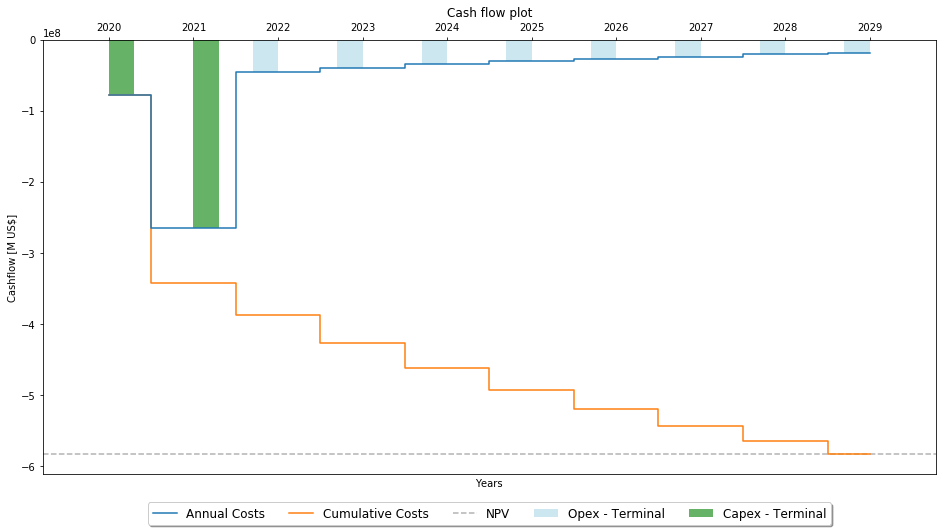

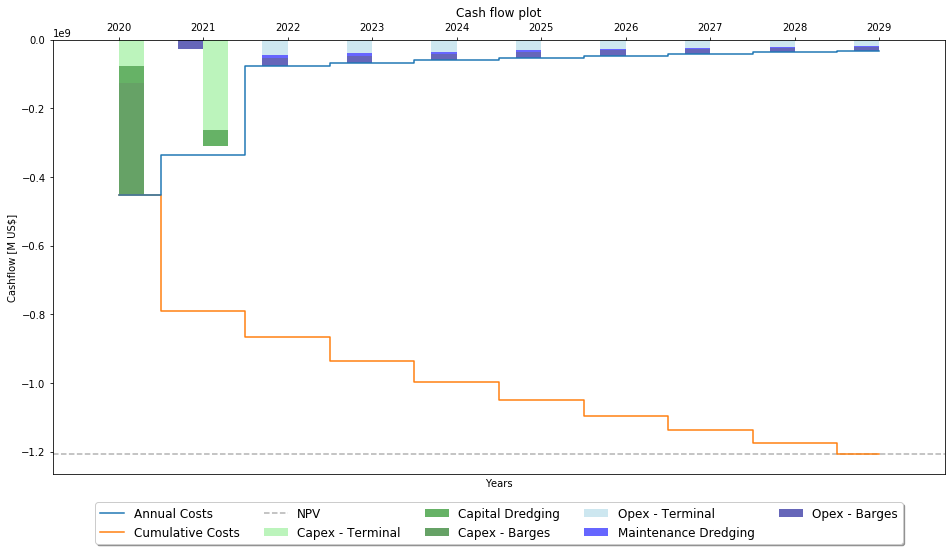

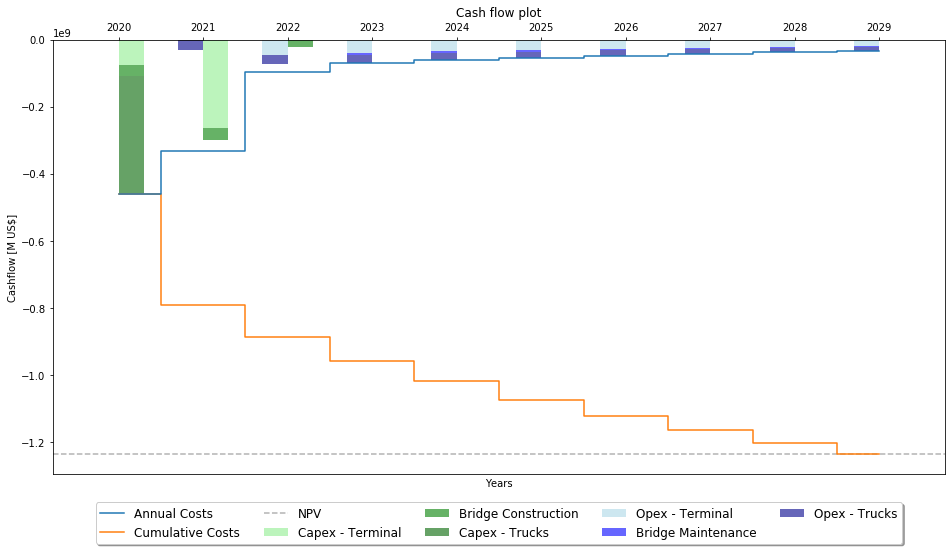

In [22]:
print('\033[1m Cash Flow Plot - Weighted average cost of capital \033[0m')
Onshore.cashflow_plot(Onshore.cash_flows_WACC_real_df)
OffshoreBarge.cashflow_plot(OffshoreBarge.cash_flows_WACC_real_df)
OffshoreBridge.cashflow_plot(OffshoreBridge.cash_flows_WACC_real_df)

In [23]:
NPVs = [round(Onshore.NPV,-6), round(OffshoreBarge.NPV,-6), round(OffshoreBridge.NPV,-6)]
print(NPVs)

[-582000000.0, -1206000000.0, -1234000000.0]


NPV 40 km, New-Panamax

[-519000000.0, -1206000000.0, -1234000000.0]